In [37]:
%matplotlib inline
import matplotlib.pyplot as plt

In [33]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

# Import the backtrader platform
import backtrader as bt

In [34]:
# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (
        ('exitbars', 5),
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] < self.dataclose[-1]:
                    # current close less than previous close

                    if self.dataclose[-1] < self.dataclose[-2]:
                        # previous close less than the previous close

                        # BUY, BUY, BUY!!! (with default parameters)
                        self.log('BUY CREATE, %.2f' % self.dataclose[0])

                        # Keep track of the created order to avoid a 2nd order
                        self.order = self.buy()

        else:

            # Already in the market ... we might sell
            if len(self) >= (self.bar_executed + self.params.exitbars):
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()



In [35]:
if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(TestStrategy)

    # Datas are in a subfolder of the samples. Need to find where the script is
    # because it could have been called from anywhere
    #modpath = os.path.dirname(os.path.abspath(sys.argv[0]))
    #datapath = os.path.join(modpath, '../data/BTC-USD.csv')

    cwd = os.getcwd()
    datapath = os.path.join(cwd, '../data', 'BTC-USD.csv')


    # Create a Data Feed
    data = bt.feeds.YahooFinanceCSVData(
        dataname=datapath,
        # Do not pass values before this date
        fromdate=datetime.datetime(2023, 6, 19),
        # Do not pass values before this date
        todate=datetime.datetime(2024, 6, 19),
        # Do not pass values after this date
        reverse=False)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(100000.0)

    # Add a FixedSize sizer according to the stake
    #cerebro.addsizer(bt.sizers.FixedSize, stake=10)

    # Set the commission - 0.1% ... divide by 100 to remove the %
    cerebro.broker.setcommission(commission=0.001)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()
    
    # Plot the strategy results
    cerebro.plot(style='candlestick', iplot=True, volume=False)

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())


Starting Portfolio Value: 100000.00
2023-06-19, Close, 26851.03
2023-06-19, BUY CREATE, 26851.03
2023-06-20, BUY EXECUTED, Price: 26841.66, Cost: 26841.66, Comm 26.84
2023-06-20, Close, 28327.49
2023-06-21, Close, 30027.30
2023-06-22, Close, 29912.28
2023-06-23, Close, 30695.47
2023-06-24, Close, 30548.70
2023-06-25, Close, 30480.26
2023-06-25, SELL CREATE, 30480.26
2023-06-26, SELL EXECUTED, Price: 30480.52, Cost: 26841.66, Comm 30.48
2023-06-26, OPERATION PROFIT, GROSS 3638.86, NET 3581.54
2023-06-26, Close, 30271.13
2023-06-26, BUY CREATE, 30271.13
2023-06-27, BUY EXECUTED, Price: 30274.32, Cost: 30274.32, Comm 30.27
2023-06-27, Close, 30688.16
2023-06-28, Close, 30086.25
2023-06-29, Close, 30445.35
2023-06-30, Close, 30477.25
2023-07-01, Close, 30590.08
2023-07-02, Close, 30620.77
2023-07-02, SELL CREATE, 30620.77
2023-07-03, SELL EXECUTED, Price: 30624.52, Cost: 30274.32, Comm 30.62
2023-07-03, OPERATION PROFIT, GROSS 350.20, NET 289.30
2023-07-03, Close, 31156.44
2023-07-04, Clos

<IPython.core.display.Javascript object>

Final Portfolio Value: 124804.39


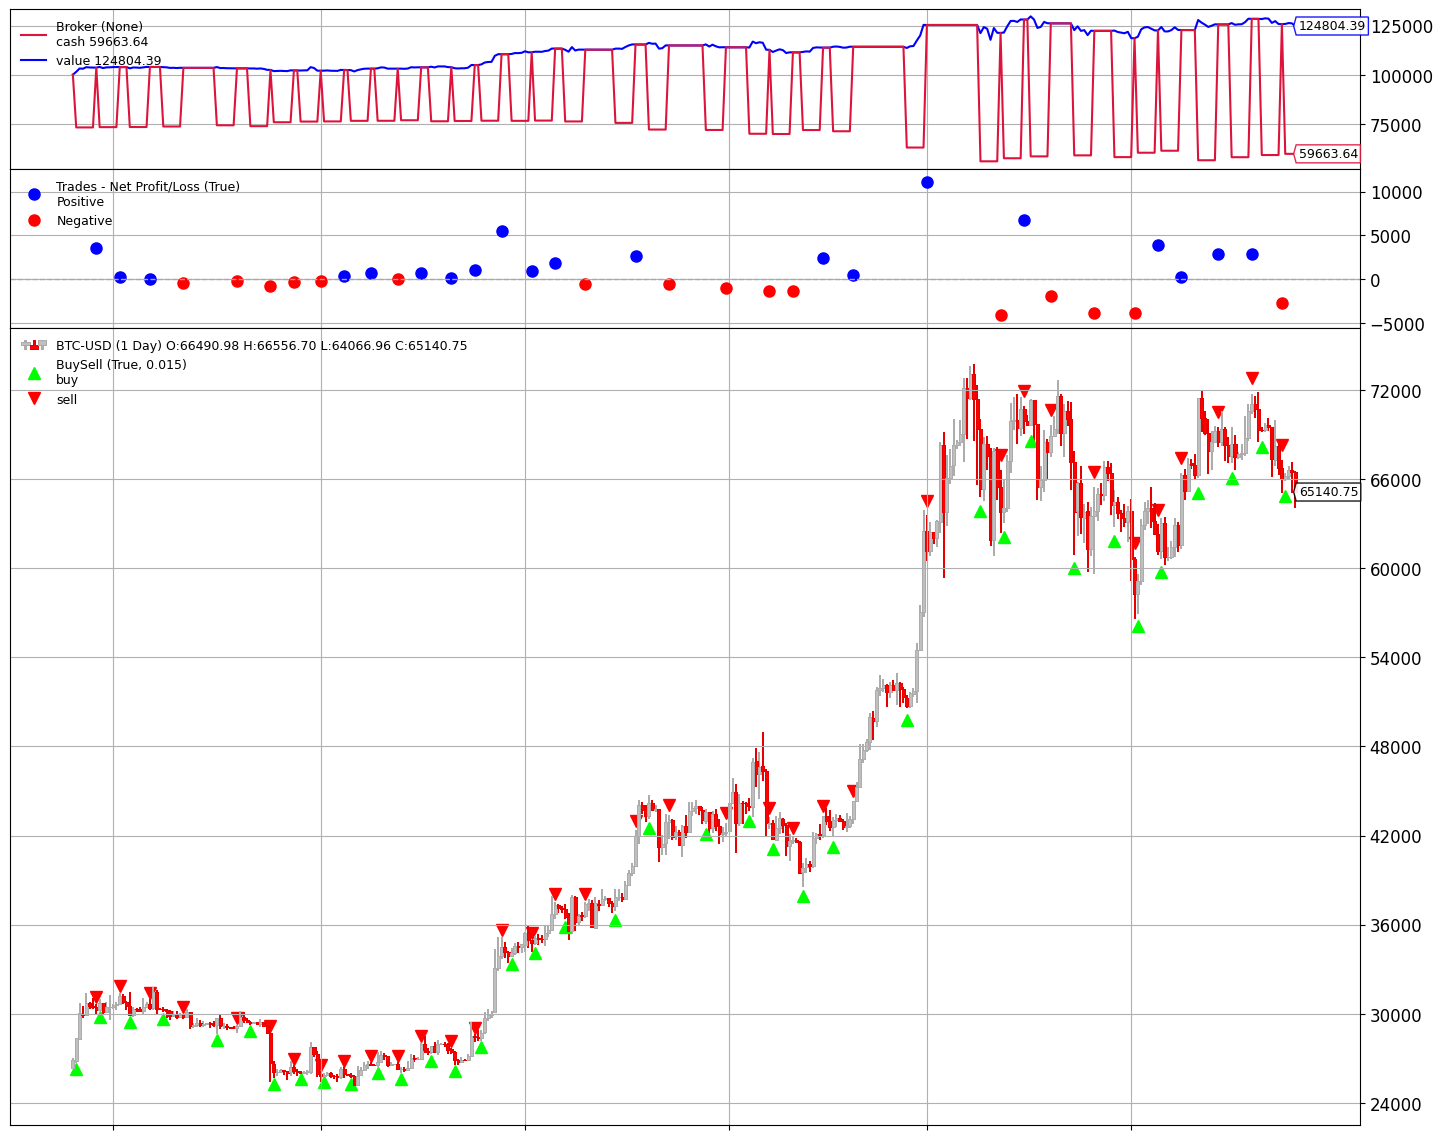

[[<Figure size 1500x1200 with 3 Axes>]]

In [39]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15, 12]
plt.rcParams.update({'font.size': 12}) 
cerebro.plot(iplot=False, volume=False, style='candlestick')